In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#my modules
from utilities import *
from nn_arch_MF import *

#required for RF
import random
from sklearn.ensemble import RandomForestClassifier

In [2]:
# global parameters
save_figures = 0
avoid_random_seeding = 1 #always influences RF, for NN it doesn't affect loaded Nets 

# NN mode
net_name = 'net_9'
load_net_params = True
train_net       = True
save_net_params = False

# Problem Formulation

A database of the Balance Sheet of 10.000 German companies (mostly SMEs) is given, covering 3 years (2016-2018).
Each entry comprises 22 Balance Sheet accounts and the estimated rating classes provided by Mode Finance (MORE evaluation - Score 20xx). 

In this work we assume that the given Credit Rating score is the "correct" one, and we will investigate possible solutions to estimate it in the case of missing input data.


The hierarchical structure of these accounts is shown in the picture. We now refer to "Levels" (0,1,2,3) based on the distance from the initial node.

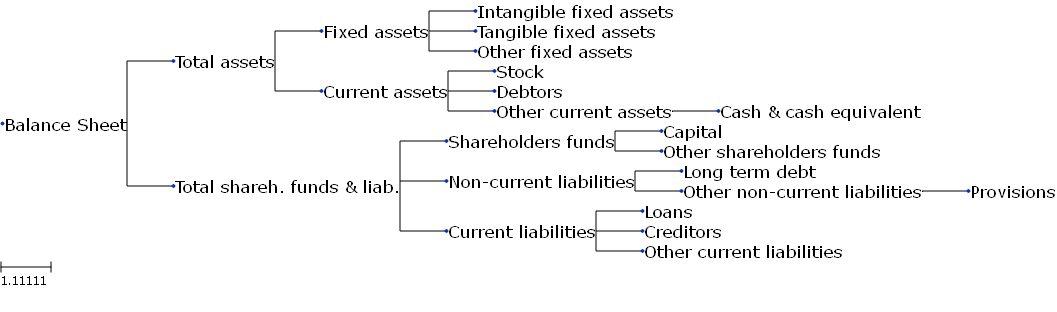

In [3]:
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node
df =  pd.read_csv('bs_tree.csv', delimiter=";")

#function "add_item"
def add_item(t,entry):
    try:
        if type(entry[0]) == str:
            for child in t.get_children():
                if  entry[0] == child.name:
                    add_item(child,entry[1:])
                    return
            t.add_child(name=entry[0])
            add_item(t.get_children()[-1],entry[1:])
    except:
        return

#define layout
ts = TreeStyle()
ts.show_leaf_name = False
def my_layout(node):
        F = TextFace(node.name, tight_text=False)
        add_face_to_node(F, node, column=0, aligned = False, position="branch-right")
ts.layout_fn = my_layout

#build tree 
t = Tree('Balance Sheet;')
for row in df.itertuples(): 
    add_item(t,row[1:])

# not possible to save directly as eps
if save_figures:
    t.render('tree.svg', dpi=200, tree_style=ts)
    
#show tree
t.render("%%inline",tree_style=ts)  


In [4]:
level_1_mask = ['Fixed assets', 'Current assets', 'Shareholders funds', 'Non-current liabilities', 'Current liabilities']
level_2_mask = ['Intangible fixed assets','Tangible fixed assets','Other fixed assets','Stock' ,'Debtors' ,'Other current assets','Capital','Other shareholders funds','Long term debt','Other non-current liabilities' ,'Loans' ,'Creditors','Other current liabilities' ]
#level_2_mask = ['Intangible fixed assets','Tangible fixed assets','Other fixed assets','Stock' ,'Debtors' ,'Cash & cash equivalent','Capital','Other shareholders funds','Long term debt','Other non-current liabilities' ,'Loans' ,'Creditors','Other current liabilities' ]

Some pre-processing was required, so the original database has been modified as follows:

- each year is considered separately, so the database appears one of 30.000 separate companies

- the database is extended to include the "Section" code (NACE classification) for each company. This categorical entry is one-hot encoded before training  NN and Random Forest classifier

- an additional database is created with financial ratios derived from the Balance Sheet information (described in PART 2)

- in both cases only SME are considered, by selecting companies with Total Assets < 43M (according to German regulation). SME account for >98% of the original database

## Missing Features Statistics

The database is first analyzed in terms of missing data (SME only).

The "Level 1" (Fixed assets, Current assets, Shareholders funds, Non-current liabilities, Current liabilities) don't present systematic trends of missing data, since their publication is mandatory by law.
Therefore we concentrate on "Level 2" items.

In [5]:
# use data_handler Class to load training and test data
dh_0 = DataHandler()
dh_0.complete_only = False
dh_0.incomplete_only = False
dh_0.full_db = True
dh_0.fill_nans_as_zeros = False
dh_0.ratios_db = False          #if True: uses ratios DB instead
dh_0.SME_only = True
dh_0.NACE_classification = False

df_0_X,df0_y = dh_0.load_as_pandas()

In [6]:
# percentage of Level 1 missing data by column
level1_incmplete_percentage = round(df_0_X[level_1_mask].isnull().sum()/df_0_X[level_1_mask].shape[0]*100,2)
print('Percentage of incomplete Level 1 entries:')
print(level1_incmplete_percentage)

Percentage of incomplete Level 1 entries:
Fixed assets               0.00
Current assets             0.00
Shareholders funds         0.01
Non-current liabilities    0.00
Current liabilities        0.00
dtype: float64


In [7]:
# percentage of Level 2 missing data by column
level2_incmplete_percentage = round(df_0_X[level_2_mask].isnull().sum()/df_0_X[level_2_mask].shape[0]*100,2)
print('Percentage of incomplete Level 2 entries:')
print(level2_incmplete_percentage)

Percentage of incomplete Level 2 entries:
Intangible fixed assets           2.13
Tangible fixed assets             2.13
Other fixed assets                2.13
Stock                             0.81
Debtors                           0.81
Other current assets              0.20
Capital                           1.92
Other shareholders funds          2.01
Long term debt                    0.11
Other non-current liabilities     0.11
Loans                            43.01
Creditors                        42.94
Other current liabilities        37.09
dtype: float64


There are 6 main "Level 2" (branched 3 times from the initial node) categories in which data may be missing (others are sub-categories of these):
- Intangible/Tangible fixed assets
- Stock/Debtors
- Other Current assets
- Capital/Other shareholders funds
- Long term debt/Other non-current liabilities
- Loans/Creditors

In [8]:
df_0__ = df_0_X[['Intangible fixed assets','Stock','Other current assets',\
                 'Other shareholders funds','Long term debt','Loans']]
df_bool = df_0__.isnull()#dh_0.__dict__

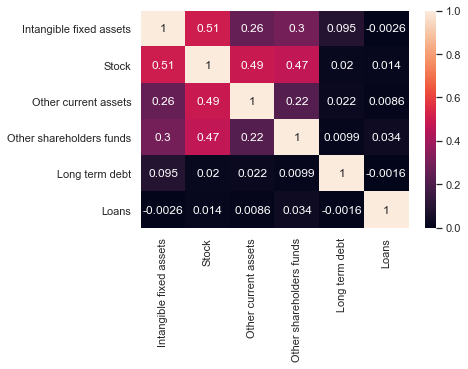

In [9]:
ax = sns.heatmap(df_bool.corr(),annot=True)

if save_figures:
    fig = ax.get_figure()
    fig.savefig('corr_1.eps')


The correlation between the occurrences of missing data among these 6 categories shows that when some info is missing on the asset side (current or non-current), it is likely that also others are missing, while there is not a significant correlation between info on the asset side and on the liabilities side, and within this last group.

Therefore, we identify 3 clusters, which we will then use to compare the classification/regression methods:
- "Asset Side" missing data (Intangible/Tangible fixed assets, Stock/Debtors, Other Current assets, Capital/Other shareholders funds)
- Long Term Debt missing data
- Loans missing data

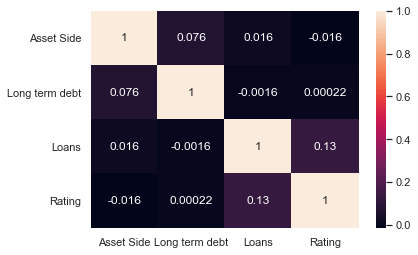

In [10]:
df_bool_2 = df_bool
df_bool_2['Rating'] = df0_y['Rating']
df_bool_2['Asset Side'] = df_bool_2[['Intangible fixed assets','Stock',\
                                    'Other current assets','Other shareholders funds']].any(axis='columns')
df_bool_2 = df_bool_2.drop(['Intangible fixed assets','Stock','Other current assets','Other shareholders funds'], axis=1)
df_bool_2 = df_bool_2[['Asset Side','Long term debt','Loans','Rating']]

# plot correlation heatmap
ax = sns.heatmap(df_bool_2.corr(),annot=True)

if save_figures:
    fig = ax.get_figure()
    fig.savefig('corr_2.eps')

From the correlation analysis, it appears as the missing information has little correlation with the credit rating, with the maximum impact imputable to lack of Loans information. 

In [11]:
# PART 1: NN on full database (with missing data)

# First Method (NN)

Rating classes are considered a linear scale from 1 (D) to 10 (AAA). The classification problem is therefore transformed into a regression one.

The attribute condensed_classes of the DataHandler() class allows to lump rating classes at the extremes (AAA/AA/A, and CC/C/D), since they have few values.

The NN regressor from class Net() are based on Pytorch.
NNs can have a variable number of Linear layers (maximum 5).
If load_net_params==1 a saved instance is loaded and all parameters overwritten. Training is automatically run on GPU if Cuda is available.

In [12]:
path = os.path.abspath(os.getcwd())

#build path differently for Windows or Linux
if os.name == 'nt':
    path_log = path + '\\log'   
else: 
    path_log = path + '/log'

# verify if it is possible to run code on the GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [13]:
# use data_handler Class to load training and test data
dh = DataHandler()

dh.complete_only = False
dh.incomplete_only = False
dh.full_db = True
dh.fill_nans_as_zeros = True
dh.remove_incomplete_y = True

dh.ratios_db = False          #if True: uses ratios DB instead
dh.condensed_classes = True  #if True: uses unique rating classes for AAA/AA/A and CC/C/D
dh.SME_only = True

dh.normalize_features = True
dh.NACE_classification = True

df_X,df_y = dh.load_as_pandas()
X,y       = dh.load_as_numpy()

NN is trained/tested on the full database (including entries with missing features), with min-Max normalized features. For the missing data, NaNs are replaced with 0. 

In [14]:
#initialize NN
if load_net_params:
    net = Net()    
    net.load_net_params(path_log,net_name)
    
    tensors_file_name = os.path.join(path_log, 'tensors_'+net_name)
    load_dict = torch.load(tensors_file_name)
    
    train_X = load_dict['X_tr']
    train_y = load_dict['y_tr']
    test_X = load_dict['X_ts']
    test_y = load_dict['y_ts']

else:
    #generate Torch dataset
    torch_gen = TorchDatasetsGenerator(0.2,disable_shuffle = avoid_random_seeding)
    train_X, train_y, test_X, test_y = torch_gen.generate_torch_dataset(X,y)
    
    N_inputs = X.shape[1] 
    N_outputs = 1
    net = Net(N_inputs , N_outputs,round(1.5*N_inputs), 10)
    # network structure only needed in first initialization, not for loaded networks

net.lr = 0.001
net.BATCH_SIZE = 600
net.device = device
net.to(device)
net.weights_dict = generate_weights_dict(dh.condensed_classes)

In [15]:
# (re-)train NN
if train_net:
    net.device = device
    net.to(device)
    net.EPOCHS = 10
    net.train_my_nn(train_X, train_y, test_X, test_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.90it/s]


In [16]:
# calculate number of neurons per layer to generate graph  
layers_graph = np.array([net.n_inputs, net.n_layer_1 ])
i = 2

while hasattr(net, 'n_layer_'+str(i)):
    #print(getattr(net, 'n_layer_'+str(i) ))
    layers_graph = np.append(layers_graph,getattr(net, 'n_layer_'+str(i) ) )
    i += 1
 
layers_graph = np.append(layers_graph,net.n_outputs)

<Figure size 864x864 with 0 Axes>

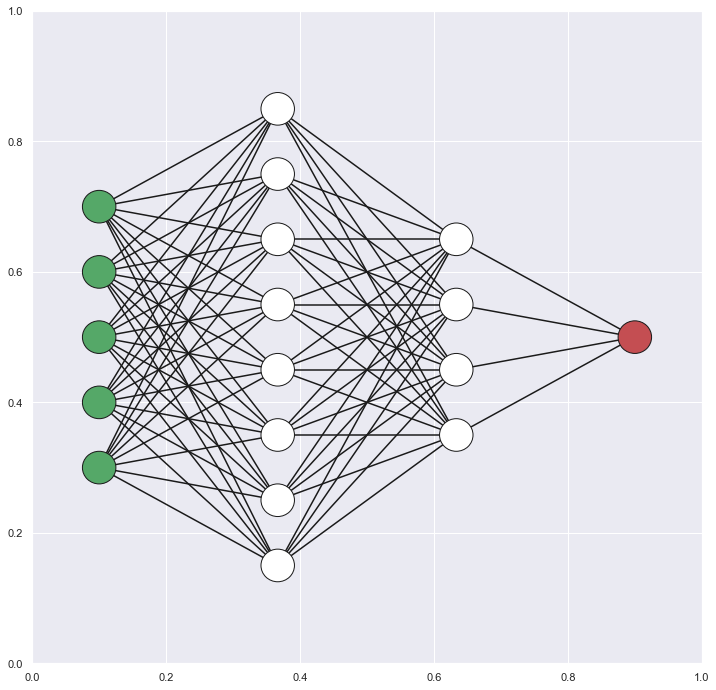

In [17]:
# a reduced number of neurons per layer is shown for clarity
layers_graph = [5 ,8 ,4 ,1]

fig = plt.figure(figsize=(12, 12))
fig = draw_neural_net(.1, .9, .1, .9, layers_graph)

if save_figures:
    fig.savefig('nn_graph.eps')

Training and Test losses are normalized with respect to the max value.

They are two different functions:

- Training Loss is done using a weighted MSE, where errors in classes with fewer samples (AAA/AA/A and CC/C/D) are weighted more
- Test Loss is plain MSE

<Figure size 864x864 with 0 Axes>

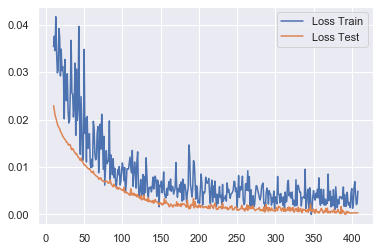

In [18]:
# plot (normalized) training history
fig = net.plot_training_log(10)

if save_figures:
    fig.savefig('train_hist.eps')
    
    

## Prediction Results

In [19]:
# calculate prediction on test sample test_X, test_y
pred_y,accuracy = net.run_test_prediction(test_X, test_y, dh.condensed_classes, print_acc = False)


The NN regressor is evaluated against the test sample (20% of the total).
Accuracy and confusion matrix are shown below.

In [20]:
print_accuracies(test_y.numpy(), pred_y)

#average deviation in the prediction
print('')
print(f'Average prediction deviation: {round(np.average(pred_y.reshape(-1,1)-test_y.numpy().reshape(-1,1)),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 71.42%
Accuracy_1 = 98.56%

Average prediction deviation: 0.02


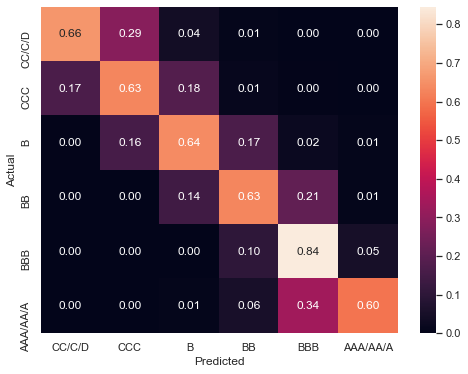

In [21]:
# plot confusion matrix
fig = plot_confusion_matrix(test_y, pred_y, dh.condensed_classes)
if save_figures:
    fig.savefig('CM_NN.eps')
    


For different splits Train/Test, Accuracy in the prediction of the test data-set is in the 72%-74% range. If the selection of the neighboring class is tolerated, Accuracy increases to ~99%.

The average prediction error is close to 0 (-0.04). That could mean that the NN learned how to assign the correct class in average, without introducing bias.

In [22]:
# save network parameters
if save_net_params:
    net.save_net_params(path_log,net_name)
    
    save_dict = {'X_tr': train_X, 'y_tr': train_y, 'X_ts': test_X, 'y_ts': test_y}

    tensors_file_name = os.path.join(path_log, 'tensors_'+net_name)
    torch.save(save_dict, tensors_file_name)

### Results by type of missing data

In [23]:
# select test samples with Asset-side missing data
X_nn_as = df_X[df_bool_2['Asset Side'].values].values
y_nn_as = df_y[df_bool_2['Asset Side'].values].values
# convert to torch
torch_gen = TorchDatasetsGenerator(1.0)
train_X, train_y, test_X, test_y = torch_gen.generate_torch_dataset(X_nn_as,y_nn_as)
# predict on test-set
pred_as_y,accuracy = net.run_test_prediction(test_X, test_y, dh.condensed_classes, print_acc = False)
#print accuracies
print_accuracies(y_nn_as, pred_as_y)

#average deviation in the prediction
print(f'Average prediction deviation: {round(np.average(pred_as_y-y_nn_as),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 64.38%
Accuracy_1 = 97.46%
Average prediction deviation: -0.05


In [24]:
# select test samples with Long Term Debt missing data
X_nn_ltd = df_X[df_bool_2['Long term debt'].values].values
y_nn_ltd = df_y[df_bool_2['Long term debt'].values].values
# convert to torch
torch_gen = TorchDatasetsGenerator(1.0)
train_X, train_y, test_X, test_y = torch_gen.generate_torch_dataset(X_nn_ltd,y_nn_ltd)
# predict on test-set
pred_ltd_y,accuracy = net.run_test_prediction(test_X, test_y, dh.condensed_classes, print_acc = False)
#print accuracies
print_accuracies(y_nn_ltd, pred_ltd_y)

#average deviation in the prediction
print(f'Average prediction deviation: {round(np.average(pred_ltd_y-y_nn_ltd),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 46.88%
Accuracy_1 = 96.88%
Average prediction deviation: -0.12


In [25]:
# select test samples with Loans missing data
X_nn_loan = df_X[df_bool_2['Loans'].values].values
y_nn_loan = df_y[df_bool_2['Loans'].values].values
# convert to torch
torch_gen = TorchDatasetsGenerator(1.0)
train_X, train_y, test_X, test_y = torch_gen.generate_torch_dataset(X_nn_loan,y_nn_loan)
# predict on test-set
pred_loan_y,accuracy = net.run_test_prediction(test_X, test_y, dh.condensed_classes, print_acc = False)
#print accuracies
print_accuracies(y_nn_loan, pred_loan_y)

#average deviation in the prediction
print(f'Average prediction deviation: {round(np.average(pred_loan_y-y_nn_loan),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 74.49%
Accuracy_1 = 99.43%
Average prediction deviation: -0.02


In the NN regressor case, predictions when Long Term Debt information is missing generated the largest percentage of misclassifications.

In particular, for the lowest class half of the companies were rated in class B, instead of (CC/C/D). This might be due to a conservative approach used by MF, which might have assumed a "worst case scenario" for them. 

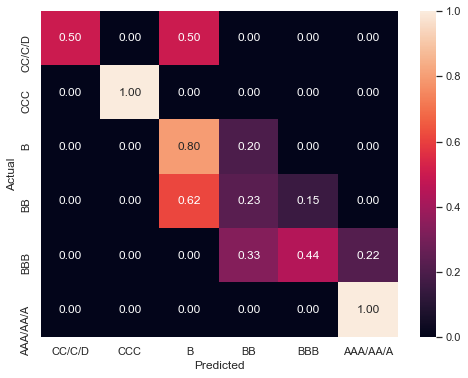

In [26]:
# confusion matric Long Term Debt

# plot confusion matrix
fig = plot_confusion_matrix(y_nn_ltd, pred_ltd_y, dh.condensed_classes)


# Second Method (EM Imputation + Random Forest Classifier)

In [27]:
# PART 2: EM imputation + Random Forest Classifier

In [28]:
# use data_handler Class to load training data
dh_test = DataHandler()
dh_test.full_db = False
dh_test.complete_only = True
dh_test.incomplete_only = False
dh_test.ratios_db = True          #if True: uses ratios DB instead
dh_test.SME_only = True
dh_test.normalize_features = False
dh_test.NACE_classification = True

# initially consider all rating classes
dh_test.condensed_classes = False
df_X_all_classes ,df_y_all_classes = dh_test.load_as_pandas()

# then group rating classes with few elements 
dh_test.condensed_classes = True

X_ ,y_ = dh_test.load_as_numpy()
df_X_ ,df_y_ = dh_test.load_as_pandas()

## Financial Ratios Definition

In the second approach, financial ratios are obtained from the Balance Sheet items in the original database.

In order to compute the ROA and ROE indicators, a proxi for the Net Income is calculated as the difference between Total Equity of two consecutive years (under the assumption that all earnings and losses are retained).

Moreover, without information about Revenues and Cost of Goods Sold, the Cash Conversion Cycle is approximated as:

(Inventories + Account Receivables - Account Payables) / Total assets

This CCC proxi is heavily flawed, and differently from the CCC it doesn't provide any indicator on the average conversion time of items into cash. Nevertheless, it provides an indicator of the overall impact of the non-cash short term accounts, normalized to the size of the company. 

The ratios are listed below:

In [29]:
fin_ratios = df_X_.columns[0:10]
print(*fin_ratios, sep = "\n")

Total assets
Current Ratio
Quick Ratio
Cash Ratio
ROA
ROE
D/E
ROIC
Tang/Total Assets
CCC proxi


## RF Training

The training of the Random Forest classifier is re-balanced, in order to be able to have acceptable predictions also in case of rating classes with few samples. Classes are divided in "frequent" (BB, BBB), "common" (B, CCC) and "unusual" (AAA/AA/A, CC/C/D).

The right proportion in the samples belonging to different classes is chosen via trial and error approach.

Here, the proportion used is 10/8/3, using 5250 randomly chosen samples from the complete portion of the database. In total, 52,84% of the available "complete" entries are used.

In [30]:
seeds = [0,1,2,3]

In [31]:
# define sampling of classes in order to have a weighted-training of the random forest classifier
# (otherwise samples distribution too imbalanced)

samples_unit = 250
weights_classes = [10,8,3]  #proportion of frequent, common, and unusual samples in training phase

if avoid_random_seeding:
    random.seed(seeds[0])
else:
    random.seed(None)
idx_unusual = df_y_['Rating'].isin([3,8])
indices_unusual = random.sample(list(idx_unusual[idx_unusual].index), weights_classes[2]*samples_unit)
#idx_unusual[idx_unusual].index.tolist()

if avoid_random_seeding:
    random.seed(seeds[1])
else:
    random.seed(None)
idx_frequent = df_y_['Rating'].isin([6,7])
indices_frequent = random.sample(list(idx_frequent[idx_frequent].index), weights_classes[0]*samples_unit)

if avoid_random_seeding:
    random.seed(seeds[2])
else:
    random.seed(None)
idx_common = df_y_['Rating'].isin([4,5])
indices_common = random.sample(list(idx_common[idx_common].index), weights_classes[1]*samples_unit)

if avoid_random_seeding:
    random.seed(seeds[3])
else:
    random.seed(None)
#indices_frequent
indices =  indices_unusual + indices_frequent + indices_common
random.shuffle(indices)

portion_used = round(len(indices)/len(y_)*100,2)
print(f'Portion of complete database used for training: {portion_used}%')

print(' ')
print(indices[0:5])

Portion of complete database used for training: 52.84%
 
[18952, 27635, 13555, 10565, 14476]


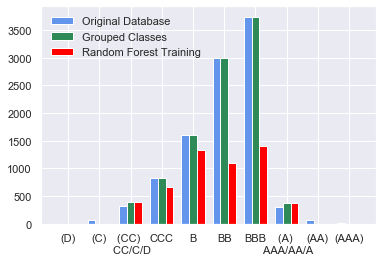

In [32]:
# plot distribution of samples across classes

bins = [-0.5]+np.arange(1,12)

a_heights, a_bins = np.histogram(df_y_all_classes, bins=bins)
b_heights, b_bins = np.histogram(df_y_, bins=bins)
c_heights, c_bins = np.histogram(df_y_.loc[indices], bins=bins)

fig, ax = plt.subplots()
labels = np.flipud(['(AAA)', '(AA)', '(A) \n AAA/AA/A' , 'BBB', 'BB', 'B', 'CCC', '(CC) \n CC/C/D' , '(C)','(D)'])
plt.xticks(range(1,11), labels)

width = (a_bins[1] - a_bins[0])/4

ax.bar(a_bins[:-1]-1*width+0.5, a_heights, width=width, label = 'Original Database', facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+0*width+0.5, b_heights, width=width, label = 'Grouped Classes', facecolor='seagreen')
ax.bar(c_bins[:-1]+1*width+0.5, c_heights, width=width,label = 'Random Forest Training', facecolor='red')

ax.legend(loc='upper left', frameon=False)

if save_figures:
    fig = plt.gcf()
    fig.savefig('classes_distrib.eps')

In the diagram above, the frequency of entries in the different classes is shown for:

- Original Database (complete portion of the database)
- Grouped Classes (the one above where AAA/AA/A and CC/C/D are lumped)
- Random Forest Training-set

In [33]:
# train/test split on the complete portion of the database

X_train = df_X_.loc[indices].values
y_train = df_y_.loc[indices].values

#X_test_db_complete = X_
#y_test_db_complete = y_
X_test_db_complete= df_X_.drop(indices).values
y_test_db_complete= df_y_.drop(indices).values

In [34]:
#RANDOM FOREST TRAINING
if avoid_random_seeding:
    random_state = 10
else:
    random_state = np.random.randint(100)

model = RandomForestClassifier(n_estimators=300, random_state=random_state)
model.fit(X_train,y_train.reshape(y_train.shape[0],))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

The RF predicts correctly:
- 100% of the samples used for the training
- 75%-80% of complete samples not used for training (exact prediction)
- 98%-99% with one class of tolerance
These results are out-performing the NN when missing data is not considered, with a comparable (very low) bias in the prediction (+-0.05). 

In [35]:
# ACCURACY COMPUTATIONS

m_sc_tr = model.score(X_train, y_train)
m_sc_tr = round(m_sc_tr*100,2)
print(f'Accuracy (training-set): {m_sc_tr}%')
print('')

"""
m_sc_test = model.score(X_test_db_complete, y_test_db_complete)
m_sc_test = round(m_sc_test*100,2)
print(f'Accuracy (non-training complete fields): {m_sc_test}%')
"""

# predict on complete portion of the test-set
y_pred_db_complete = model.predict(X_test_db_complete)

print_accuracies(y_test_db_complete, y_pred_db_complete)

#average deviation in the prediction (test dataset)
print('')
print(f'Average prediction deviation: {round(np.average(y_pred_db_complete.reshape(-1,1)-y_test_db_complete.reshape(-1,1)),2)}')

Accuracy (training-set): 100.0%

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 76.72%
Accuracy_1 = 98.06%

Average prediction deviation: -0.03


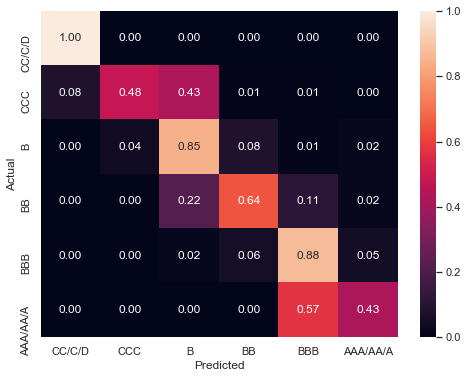

In [36]:
# plot confusion matrix
fig = plot_confusion_matrix(y_test_db_complete, y_pred_db_complete, dh.condensed_classes)
if save_figures:
    fig.savefig('CM_RF.eps')

##  Data Imputation

Now the full database has to be imputed, in order to feed the RF classifier. EM method is used for imputation (implementation in the folder db_generation).

This procedure occurs in 2 steps:
1. the entire database is used for the imputation phase
2. the entries which were originally used for the training of the RF classifier are dropped (in this way the test phase doesn't include any sample already used for the training)

In [53]:
#TESTING on IMPUTED Database, not considering entries used for the training
dh_test.imputed_db = True
dh_test.imputed_zeros_as_nans = False #######ONLY SET TRUE TO IMPUTE THE DATASET ASSUMING ALL ZEROS == NANS
dh_test.full_db = True

df_X_imp ,df_y_imp = dh_test.load_as_pandas()

X_imp_test = df_X_imp.drop(indices,axis=0).values
y_imp_test = df_y_imp.drop(indices,axis=0).values


### Imputation assuming 0 == NaN
In the available dataset it can occur that some entries == 0 are i indeed NaNs.
In particular for the D/E ratio, one has that approximately 17% of all instances are equal to 0.

One possible solution is to run the EM imputation assuming all values == 0 are indeed NaNs.
The user can check the classification performance by setting "dh_test.imputed_zeros_as_nans = True" on the cell above.

It was found that classification performance deteriorates slightly in this case.


In [77]:
print(df_X_imp.columns[0:10])

aa = X_imp_test[:,0:10]
out = (aa == 0).sum(axis = 0)
print(f'Percentage of zeros in D/E column: {round(out[6]/aa.shape[0]*100,2)}%')

Index(['Total assets', 'Current Ratio', 'Quick Ratio', 'Cash Ratio', 'ROA',
       'ROE', 'D/E', 'ROIC', 'Tang/Total Assets', 'CCC proxi'],
      dtype='object')
Percentage of zeros in D/E column: 17.13%


## Prediction on the Imputed Test-set

In [46]:
# predict on imputed test-set
y_imp_pred = model.predict(X_imp_test)

In [47]:
print_accuracies(y_imp_test, y_imp_pred)

#average deviation in the prediction
print('')
print(f'Average prediction deviation: {round(np.average(y_imp_pred.reshape(-1,1)-y_imp_test.reshape(-1,1)),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 68.64%
Accuracy_1 = 94.59%

Average prediction deviation: 0.16


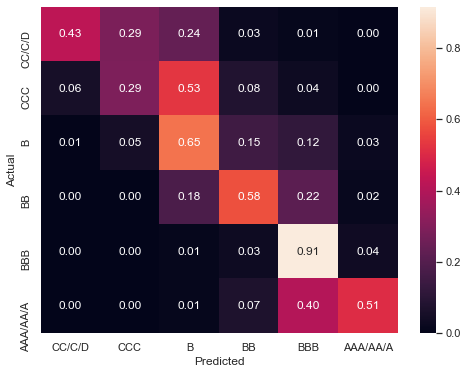

In [48]:
# plot confusion matrix
fig = plot_confusion_matrix(y_imp_test, y_imp_pred, dh_test.condensed_classes)
if save_figures:
    fig.savefig('CM_EM_RF.eps')
    


Accuracy scores are not much worse than in the NN case, but the average prediction error is considerably higher (0.16). 

That could mean that the NN learned how to assign the correct class in average, without introducing bias.

### Results by type of missing data

In [49]:
# select test samples with Asset-side missing data
X_imp_as = df_X_imp[df_bool_2['Asset Side'].values].values
y_imp_as = df_y_imp[df_bool_2['Asset Side'].values].values
# predict on test-set
y_imp_as_pred = model.predict(X_imp_as)
#print accuracies
print_accuracies(y_imp_as, y_imp_as_pred)

#average deviation in the prediction
print(f'Average prediction deviation: {round(np.average(y_imp_as_pred-y_imp_as),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 66.73%
Accuracy_1 = 92.76%
Average prediction deviation: 0.09


In [50]:
# select test samples with Long Term Debt missing data
X_imp_ltd = df_X_imp[df_bool_2['Long term debt'].values].values
y_imp_ltd = df_y_imp[df_bool_2['Long term debt'].values].values
# predict on test-set
y_imp_ltd_pred = model.predict(X_imp_ltd)
#print accuracies
print_accuracies(y_imp_ltd, y_imp_ltd_pred)

#average deviation in the prediction
print(f'Average prediction deviation: {round(np.average(y_imp_ltd_pred-y_imp_ltd),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 56.25%
Accuracy_1 = 87.5%
Average prediction deviation: -0.19


In [51]:
# select test samples with Loans missing data
X_imp_loan = df_X_imp[df_bool_2['Loans'].values].values
y_imp_loan = df_y_imp[df_bool_2['Loans'].values].values
# predict on test-set
y_imp_loan_pred = model.predict(X_imp_loan)
#print accuracies
print_accuracies(y_imp_loan, y_imp_loan_pred)

#average deviation in the prediction
print(f'Average prediction deviation: {round(np.average(y_imp_loan_pred-y_imp_loan),2)}')

Accuracy_0: Percentage of instances where exact class is detected
Accuracy_1: Percentage of instances where exact class or neighbouring class is detected
 
Accuracy_0 = 66.99%
Accuracy_1 = 93.52%
Average prediction deviation: 0.25


Also in the EM+RF case, predictions when Long Term Debt information is missing generated the largest percentage of misclassifications.

In this case, though, there is a considerably larger proportion of companies which were classified in a higher class (keeping in mind that the performance of the NN regressor is expected to perform better, due to the fact that a portion of the evaluated inputs were also used for the training).

In general, one can notice how, although the accuracy scores are not too far away from the NN case, the classifications tend to have a considerable bias when the imputed data is analyzed.

In [52]:
# confusion matrix for prediction in case of Long Term Debt and Loans 

"""
# plot confusion matrix
plot_confusion_matrix(y_imp_ltd, y_imp_ltd_pred, dh_test.condensed_classes)

# plot confusion matrix
plot_confusion_matrix(y_imp_loan, y_imp_loan_pred, dh_test.condensed_classes)
"""

'\n# plot confusion matrix\nplot_confusion_matrix(y_imp_ltd, y_imp_ltd_pred, dh_test.condensed_classes)\n\n# plot confusion matrix\nplot_confusion_matrix(y_imp_loan, y_imp_loan_pred, dh_test.condensed_classes)\n'

# CONCLUSIONS

The NN expectedly performs better than the second method. By construction, a properly trained NN is able to capture the relations within the database, although it is not trivial to explain them.

The second method consists of 4 steps:
1. definition of financial ratios and proxies to reduce the DB dimensionality
2. training of the RF classifier (simpler than NN, but efficient on lower-dimensional datasets) on the complete portion of the database, to capture relations between financial ratios and credit rating
3. imputation of missing values
4. and prediction on the RF of the imputed dataset (minus training data)

While the prediction output of the NN is excellent (~75% accuracy, ~98% of predictions maximum deviation is a neighboring class), the EM+RF method comes close in both accuracy measures (~69%, ~95%).



When considering the prediction capability of the two methods in the cases when information was missing, we found out that:
- the classification is in line with the average, in the cases where Asset-side or Loans information are missing
- performance worsens considerably when Long Term Debt information is missing

Overall considerations:
- NN uses 80% of the entire database for training
- Random Forest is trained on 17% of the full database (two reasons: 1. can't train RF on non verified imputed data, 2. training-set has to be balanced)
- given different proportion of information used, EM+RF shows good performance, and seems to validate the choice of financial indicators chosen

Possible Future Developments:
- NN training: different strategy than replacement of NaNs with 0
- NN training: considering rating evolution over years (2D inputs, or CNN if large time window is available (>= 10 years))
- trying different imputation methods (e.g. based on autoencoder)
- explaining why EM+RF introduces bias in the rating estimation